### Data Exploration for the Twitter Election Interference Dataset

#### Data Import

In [ ]:
# Switch for loading previously saved data 
load_subset = True

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,10)

Let's start with reading in the data first. I failed to read the full dataset in, since it's too big (almost 6GB). Loading a subset in we can see that many tweets are in cyrillic or not in english. Since we can only sensibly work in english, we can immediately start reducing the amount of data by only loading the english tweets.

In [2]:
if load_subset:
    tweet_data = pd.read_csv("../data/ira_tweets_en.csv")

# Read in data, immediately discard rows with non-english tweets, iterator yields iterators object
tweet_chunks =  pd.read_csv("../data/ira_tweets_csv_hashed.csv",iterator = True, chunksize = 10000)

# Concatentate all chunks, filtering for english tweets
tweet_data = pd.concat([chunk[chunk['tweet_language'] == "en"] for chunk in tweet_chunks])

In [3]:
tweet_data.shape

(2997181, 31)

That looks nice, still almost 3 million tweets! Let's go ahead and save these so we don't need to load the full data later.

In [4]:
tweet_data.to_csv("../data/ira_tweets_en.csv")

#### Data Exploration

The information on the columns can be found here https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt 

In [5]:
tweet_data.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_tweetid',
       'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [6]:
len(tweet_data.tweetid.unique())

2997181

Seems like all tweets are unique! How many users do we have?

In [7]:
len(tweet_data.userid.unique())

3077

Not that many users. Let's check where they say they are coming from.

In [8]:
tweet_data.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,...,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
8,567357519547207680,2b0d7525bed1df5119b7956f9be4888b45686172d68006...,2b0d7525bed1df5119b7956f9be4888b45686172d68006...,2b0d7525bed1df5119b7956f9be4888b45686172d68006...,California,Troublemaker,NaN,696,863,2013-08-06,...,absent,absent,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
10,493894187079974912,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,NY,NaN,NaN,103,218,2014-03-24,...,absent,absent,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
11,493688319902220288,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,NY,NaN,NaN,103,218,2014-03-24,...,absent,absent,0.0,0.0,0.0,0.0,[USA],NaN,NaN,NaN
12,497543470211678209,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,be1e8e099e93fe0964c1184173f038c7413def3baf38ef...,NY,NaN,NaN,103,218,2014-03-24,...,absent,absent,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
32,500956712657223680,004c1875a5f3a8ddfd2044b857a81c5d458882ac5cdf67...,004c1875a5f3a8ddfd2044b857a81c5d458882ac5cdf67...,004c1875a5f3a8ddfd2044b857a81c5d458882ac5cdf67...,New York,NaN,NaN,63,77,2014-05-23,...,absent,absent,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [56]:
tweet_data.user_reported_location.unique()

array(['California', 'NY', 'New York', 'USA', 'US', nan, 'Boston',
       'Chicago', 'ID', 'City of Cleveland, USA', 'Мурманск', 'NY City',
       'United States', 'Москва', 'Ohio', 'New York, USA', 'LA',
       'New Orleans, LA', 'saint P.', 'Arizona', 'Atlanta', 'NYC',
       'Estados Unidos', 'Питер', 'New York City', 'ATL, GA',
       'Atlanta, GA', 'AL', 'Italy', 'Venice, California',
       'Detroit, Michigan', 'City of San Antonio, TX',
       'Ярославль, Россия', 'portland', 'Chicago, IL', 'Washington, DC',
       'USA, Atlanta', 'Atlanta, Georgia', 'Whitehall, Ohio', 'СПб',
       'America', 'Miami', 'Москва, Россия', 'ny', 'Miami, FL',
       'Washington, D.C.', 'Я везде', 'Greensboro', 'San Francisco, CA',
       'ПЕТЕРБУРГ', 'us', 'Российская Федерация', 'Arizona, USA',
       'Milwaukee, WI', 'San-Francisco', 'Philadelphia, PA', 'Mesa',
       'Los Angeles, CA', 'Alaska', 'Москва (СССР - Россия)',
       'Dallas, Texas', 'Hessen, Deutschland', 'Архангельск', 'Lyon',
      

Interesting. By eyeballing it, mostly self-reported to be in the US. However, some from Russia or Germany. Let's try to visualize it.


In [64]:
tweet_location = tweet_data.groupby("user_reported_location").count().sort_values("tweetid",ascending = False)
tweet_location.iloc[0:50,0]

user_reported_location
USA                               726972
United States                     266963
Los Angeles, CA                    98072
Chicago, IL                        87435
New York, NY                       67953
Atlanta                            62909
New York, USA                      57663
Kansas City, MO                    51659
New Orleans, LA                    45909
San Francisco, CA                  44711
US                                 41014
Washington, D.C.                   38015
Pittsburgh, PA                     33104
Seattle, WA                        29821
Atlanta, GA                        29634
St Louis, MO                       28726
NY                                 28226
City of Cleveland, USA             27291
Baton Rouge, LA                    26851
Texas, USA                         26337
Philadelphia, PA                   26023
City of Phoenix, Arizona           25730
StLouis                            25366
Detroit, Michigan                 

Interesting, 12400 "CITIZENS OF THE UNIVERSE". I wonder whether they all know each other. Let's visualize it.

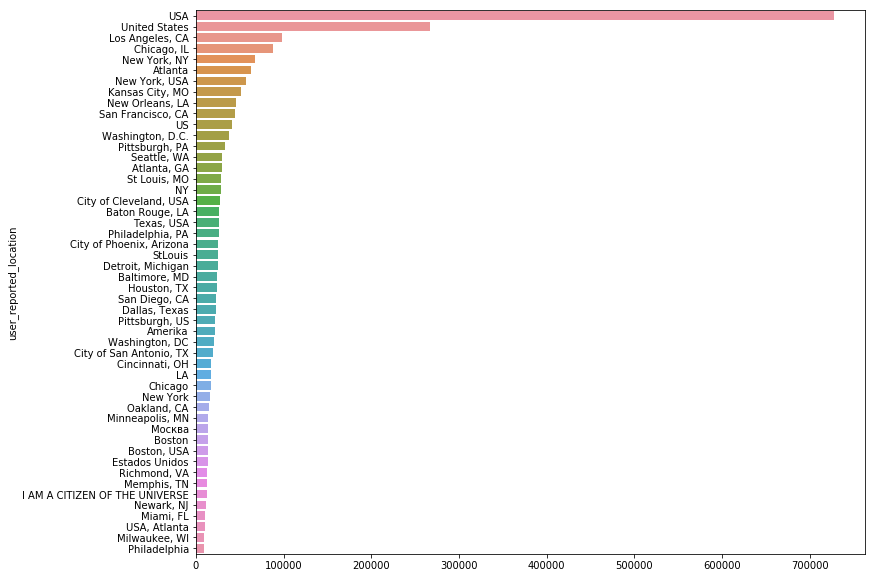

In [74]:
sns.barplot(y= tweet_location.iloc[0:50,0].index, x=tweet_location.iloc[0:50,0].values)

Many of them just state USA, which seems a bit ood. We can later check their behaviour by location. 

In [75]:
users = pd.read_csv("../data/ira_users_csv_hashed.csv")

In [76]:
users.columns

Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')

In [78]:
users.sort_values("follower_count", ascending = False).iloc[0:50]

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
954,2527472164,Вестник Москвы,NovostiMsk,Москва,Невозможно не любить этот город! Телефон редак...,https://t.co/sIJZDK1hTI,257638,544,2014-05-04,en
960,508761973,Вестник Петербурга,NovostiSPb,"Saint Petersburg, Russia",По отчеству - с Невы #Петербург #Питер #СПб #С...,https://t.co/CSP9JH0u7k,149672,1024,2012-02-29,en
2499,4224729994,Tennessee,TEN_GOP,NaN,Unofficial Twitter of Tennessee Republicans. C...,NaN,147767,74664,2015-11-19,en
3376,2808833544,Максим Дементьев,MaxDementiev,NaN,Мне не всё равно,https://t.co/nZE61mBuTF,134805,2796,2014-09-14,ru
144,449689677,Рамзан Кадыров,KadirovRussia,NaN,"Пародийный аккаунт. Озвучиваю то, что политика...",NaN,123989,10,2011-12-29,ru
1277,2648734430,Вестник Крыма,NovostiCrimea,"Crimea, Russia",Путь на родину #Крым #Севастополь #Симферополь,https://t.co/sIJZDK1hTI,106462,386,2014-07-15,en
2525,3676820373,Вестник Красноярска,NovostiKrsnrsk,"Krasnoyarsk, Russia",Жемчужина Сибири! #Красноярск #Krasnoyarsk #Си...,https://t.co/CSP9JH0u7k,85293,316,2015-09-16,en
926,2665564544,Мюсли Лаврова,LavrovMuesli,NaN,"Держу МИД, спорю с дебилами, бл@#%. Пародийный...",https://t.co/uSv8xvCXuZ,84642,2575,2014-07-21,ru
324,3729867851,Вестник Перми,NovostiPermi,"Perm, Russia",Опорный край державы #Пермь #Прм #Новости,https://t.co/CSP9JH0u7k,84167,143,2015-09-21,en
2816,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,2014-10-29,en


In [19]:
tweet_data[tweet_data.userid =="2518710111"]

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,...,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
236386,872460702149201920,2518710111,Вестник Новосибирска,NovostiNsk,"Новосибирск, Россия",Сибирь здесь! #Новосибирск #Nsk #Нск #Новосиб...,https://t.co/CSP9JHi5vU,60869,1246,2014-04-30,...,absent,absent,0.0,0.0,11.0,7.0,[],[],NaN,NaN
